**Устанавливаем библиотеки**

In [ ]:
!pip install transformers 
!pip install deeppavlov 
!pip install df_engine

In [ ]:
!pip install torch

In [ ]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

In [ ]:
import deeppavlov
import torch
import transformers
import json
import string
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from transformers import BertTokenizer, BertModel
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sklearn.__version__

'1.0.2'

**Готовим данные для обучения**

In [ ]:
with open('intents_paraphrase_expand.json', 'r') as file:
    data_str = file.read()
    
data_dict = json.loads(data_str)    

In [ ]:
phrases = []
classes_word = []
classes_for_indexing = []

for intent in data_dict['intents']:
    for pattern in intent['patterns']:
        phrases.append(pattern)
        classes_word.append(intent['tag'])
        
        if intent['tag'] not in classes_for_indexing:
            classes_for_indexing.append(intent['tag'])
            
indexed_classes =[]
for intent in classes_word:
    indexed_classes.append(classes_for_indexing.index(intent))

In [ ]:
# classes_word
# phrases
classes_for_indexing
# indexed_classes

['greeting',
 'goodbye',
 'thanks',
 'consent',
 'disagreement',
 'special_offer',
 'balance_request',
 'balance_top_up',
 'connection_application',
 'connection_problems',
 'whats_tariff',
 'change_tariff',
 'office_addresses',
 'television',
 'calling_wizard',
 'callback']

In [ ]:
len(classes_for_indexing), len(indexed_classes), len(phrases), len(classes_word)

(16, 1242, 1242, 1242)

In [ ]:
ex_len = []

ex_len.append(classes_word.count('greeting'))
ex_len.append(classes_word.count('goodbye'))
ex_len.append(classes_word.count('thanks'))
ex_len.append(classes_word.count('consent'))
ex_len.append(classes_word.count('disagreement'))
ex_len.append(classes_word.count('special_offer'))
ex_len.append(classes_word.count('balance_request'))
ex_len.append(classes_word.count('balance_top_up'))
ex_len.append(classes_word.count('connection_application'))
ex_len.append(classes_word.count('connection_problems'))
ex_len.append(classes_word.count('whats_tariff'))
ex_len.append(classes_word.count('change_tariff'))
ex_len.append(classes_word.count('office_addresses'))
ex_len.append(classes_word.count('television'))
ex_len.append(classes_word.count('calling_wizard'))
ex_len.append(classes_word.count('callback'))

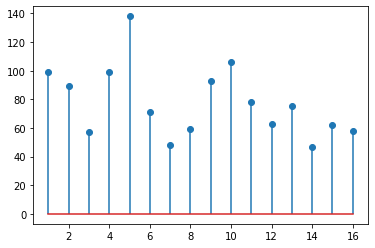

In [ ]:
x = range(1,17)
y = ex_len
  
plt.stem(x, y, use_line_collection = True)
plt.show()

In [ ]:
def preprocess_phrases(text):
    
    text_preprocessed = []
        
    for sentence in text:
        new_letter = ''
        for letter in sentence:
            if letter not in string.punctuation:
                new_letter += letter
                new_letter = new_letter.lower()    
        text_preprocessed.append(new_letter)

    return text_preprocessed

In [ ]:
preprocessed_phrases = preprocess_phrases(phrases)

In [ ]:
preprocessed_phrases[720:740]

['подключить раздачу интернета',
 'выход в интернет',
 'хочу выйти в интернет',
 'выход в интернет',
 'выход в сеть',
 'купить подключение',
 'телефонный интернет',
 'интернет для смартфона',
 'поставить модем',
 'купить модем',
 'подключить модем',
 'adsl интернет',
 'адсл интернет',
 'пакет интернета',
 'подключить adsl',
 'провести через телефон',
 'провести через тарелку',
 'интернет для организации',
 'цифровой интернет',
 'купить оптоволокно']

**Получаем эмбеддинги от Conversational RuBERT**

In [ ]:
bert_config = read_json(configs.embedder.bert_embedder)
bert_config['metadata']['variables']['BERT_PATH'] = 'ru_conversational_cased_L-12_H-768_A-12_pt'

model = build_model(bert_config)
model_input = build_model(bert_config)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.
Some weights of the model checkpoint at /content/ru_conversational_cased_L-12_H-768_A-12_pt were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on

In [ ]:
tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = model(preprocessed_phrases)

In [ ]:
# Ищем максимум и минимум
print(sent_mean_embs.min())
print(sent_mean_embs.max())

-3.234143
3.7270842


In [ ]:
# pd.DataFrame(sent_mean_embs).to_csv("embs.csv")

Делим данные на train и test 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sent_mean_embs,indexed_classes, test_size=0.25, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((931, 768), (311, 768))

**Используем LogisticRegression от Sklearn на sent_mean_embs от ruBert**

In [ ]:
logreg = LogisticRegression(C=0.1, random_state=42).fit(X_train, y_train)

Вычисляем accuracy 

In [ ]:
print("Правильность на обучающем наборе:", logreg.score(X_train, y_train))
print("Правильность на тестовом наборе:", logreg.score(X_test, y_test))

Правильность на обучающем наборе: 0.9967776584317938
Правильность на тестовом наборе: 0.7813504823151125


Вычисляем main classification metrics

In [ ]:
train_preds_logreg = logreg.predict(X_train)

test_preds_logreg = logreg.predict(X_test)

In [ ]:
print(classification_report(y_train, train_preds_logreg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00        67
           2       1.00      0.98      0.99        41
           3       0.99      1.00      0.99        68
           4       1.00      1.00      1.00       102
           5       0.98      1.00      0.99        56
           6       1.00      1.00      1.00        34
           7       1.00      1.00      1.00        46
           8       0.98      1.00      0.99        64
           9       1.00      1.00      1.00        85
          10       1.00      0.98      0.99        60
          11       1.00      1.00      1.00        44
          12       1.00      1.00      1.00        55
          13       1.00      0.97      0.99        40
          14       1.00      1.00      1.00        47
          15       1.00      1.00      1.00        44

    accuracy                           1.00       931
   macro avg       1.00   

In [ ]:
print(classification_report(y_test, test_preds_logreg))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89        21
           1       0.95      0.86      0.90        22
           2       0.91      0.62      0.74        16
           3       0.78      0.90      0.84        31
           4       0.80      0.92      0.86        36
           5       0.78      0.93      0.85        15
           6       0.70      0.50      0.58        14
           7       0.64      0.54      0.58        13
           8       0.86      0.86      0.86        29
           9       0.94      0.71      0.81        21
          10       0.58      0.61      0.59        18
          11       0.62      0.68      0.65        19
          12       0.80      0.80      0.80        20
          13       0.71      0.71      0.71         7
          14       0.73      0.73      0.73        15
          15       0.69      0.64      0.67        14

    accuracy                           0.78       311
   macro avg       0.77   

Вычисяем roc_auc_score

In [ ]:
train_preds_proba_logreg = logreg.predict_proba(X_train)

test_preds_proba_logreg = logreg.predict_proba(X_test)

In [ ]:
roc_auc_score(y_train, train_preds_proba_logreg, multi_class='ovr')

0.9999942818894616

In [ ]:
roc_auc_score(y_test, test_preds_proba_logreg, multi_class='ovr')

0.980140665599365

Вычисляем cross_val_score

In [ ]:
lr = LogisticRegression(C=0.1, random_state=42)

In [ ]:
scores = cross_val_score(lr, sent_mean_embs, indexed_classes, cv=10)
print('Значения правильности перекрёстной проверки:', scores)
print('Среднее значение правильности перекрёстной проверки:', scores.mean())


Значения правильности перекрёстной проверки: [0.768      0.824      0.7983871  0.66935484 0.74193548 0.80645161
 0.7983871  0.7983871  0.77419355 0.79032258]
Среднее значение правильности перекрёстной проверки: 0.7769419354838709


**Используем DecisionTreeClassifier от Sklearn на sent_mean_embs от ruBert**

In [ ]:
tree = DecisionTreeClassifier(max_depth=30)

In [ ]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=30)

Вычисляем accuracy

In [ ]:
print("Правильность на обучающем наборе:", tree.score(X_train, y_train))
print("Правильность на тестовом наборе:", tree.score(X_test, y_test))

Правильность на обучающем наборе: 0.9989258861439313
Правильность на тестовом наборе: 0.3215434083601286


Вычисляем main classification metrics

In [ ]:
train_preds_tree = tree.predict(X_train)

test_preds_tree = tree.predict(X_test)

In [ ]:
print(classification_report(y_train, train_preds_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00        67
           2       0.98      1.00      0.99        41
           3       1.00      0.99      0.99        68
           4       1.00      1.00      1.00       102
           5       1.00      1.00      1.00        56
           6       1.00      1.00      1.00        34
           7       1.00      1.00      1.00        46
           8       1.00      1.00      1.00        64
           9       1.00      1.00      1.00        85
          10       1.00      1.00      1.00        60
          11       1.00      1.00      1.00        44
          12       1.00      1.00      1.00        55
          13       1.00      1.00      1.00        40
          14       1.00      1.00      1.00        47
          15       1.00      1.00      1.00        44

    accuracy                           1.00       931
   macro avg       1.00   

In [ ]:
print(classification_report(y_test, test_preds_tree))

              precision    recall  f1-score   support

           0       0.19      0.24      0.21        21
           1       0.40      0.45      0.43        22
           2       0.50      0.44      0.47        16
           3       0.46      0.42      0.44        31
           4       0.32      0.33      0.33        36
           5       0.26      0.33      0.29        15
           6       0.31      0.29      0.30        14
           7       0.22      0.15      0.18        13
           8       0.63      0.41      0.50        29
           9       0.30      0.38      0.33        21
          10       0.17      0.22      0.19        18
          11       0.23      0.16      0.19        19
          12       0.40      0.40      0.40        20
          13       0.15      0.29      0.20         7
          14       0.15      0.13      0.14        15
          15       0.27      0.21      0.24        14

    accuracy                           0.32       311
   macro avg       0.31   

Вычисяем roc_auc_score

In [ ]:
train_preds_proba_tree = tree.predict_proba(X_train)

test_preds_proba_tree = tree.predict_proba(X_test)

In [ ]:
roc_auc_score(y_train, train_preds_proba_tree, multi_class='ovr')

0.9999986110878655

In [ ]:
roc_auc_score(y_test, test_preds_proba_tree, multi_class='ovr')

0.6292480157221901

Вычисляем cross_val_score

In [ ]:
scores = cross_val_score(tree, sent_mean_embs, indexed_classes, cv=10)
print('Значения правильности перекрёстной проверки:', scores)
print('Среднее значение правильности перекрёстной проверки:', scores.mean())

Значения правильности перекрёстной проверки: [0.376      0.336      0.28225806 0.25       0.2983871  0.29032258
 0.2983871  0.2983871  0.29032258 0.28225806]
Среднее значение правильности перекрёстной проверки: 0.30023225806451614


**Используем SVC-классификатор**

Попробуем LinearSVC

In [ ]:
lin_svc = LinearSVC()

In [ ]:
lin_svc.fit(X_train, y_train)

LinearSVC()

In [ ]:
print("Правильность на обучающем наборе:", lin_svc.score(X_train, y_train))
print("Правильность на тестовом наборе:", lin_svc.score(X_test, y_test))

Правильность на обучающем наборе: 0.9989258861439313
Правильность на тестовом наборе: 0.7491961414790996


А теперь просто SVC

In [ ]:
svc = SVC(C=10, gamma=0.001, probability = True)

In [ ]:
svc.fit(X_train, y_train)

SVC(C=10, gamma=0.001, probability=True)

Вычисляем accuracy

In [ ]:
# Это лучший результат
print("Правильность на обучающем наборе:", svc.score(X_train, y_train))
print("Правильность на тестовом наборе:", svc.score(X_test, y_test))

Правильность на обучающем наборе: 0.9881847475832438
Правильность на тестовом наборе: 0.8006430868167203


Вычисляем cross_val_score

In [ ]:
scores = cross_val_score(svc, sent_mean_embs, indexed_classes, cv=10)
print('Значения правильности перекрёстной проверки:', scores)
print('Среднее значение правильности перекрёстной проверки:', scores.mean())

Значения правильности перекрёстной проверки: [0.792      0.848      0.79032258 0.65322581 0.76612903 0.74193548
 0.78225806 0.7983871  0.77419355 0.78225806]
Среднее значение правильности перекрёстной проверки: 0.7728709677419354


Подключаем GridSearchCV

In [ ]:
parametrs = {'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [ ]:
grid = GridSearchCV(SVC(), parametrs, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.001}

Отмасштабируем данные

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(X_train)

MinMaxScaler()

In [ ]:
X_train_scaled = scaler.transform(X_train)

In [ ]:
X_test_scaled = scaler.transform(X_test)

In [ ]:
svc.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.001)

In [ ]:
# Результат стал похуже
print("Правильность на обучающем наборе:", svc.score(X_train_scaled, y_train))
print("Правильность на тестовом наборе:", svc.score(X_test_scaled, y_test))

Правильность на обучающем наборе: 0.8539205155746509
Правильность на тестовом наборе: 0.7781350482315113


**Используем RandomForestClassifier**

In [ ]:
rfclf = RandomForestClassifier(max_features = 27)

In [ ]:
rfclf.fit(X_train, y_train)

RandomForestClassifier(max_features=27)

In [ ]:
len(rfclf.estimators_)

100

Вычисляем accuracy

In [ ]:
print("Правильность на обучающем наборе:", rfclf.score(X_train, y_train))
print("Правильность на тестовом наборе:", rfclf.score(X_test, y_test))

Правильность на обучающем наборе: 0.9989258861439313
Правильность на тестовом наборе: 0.662379421221865


**Используем GradientBoostingClassifier**

In [ ]:
gbclf = GradientBoostingClassifier(max_depth=2)

In [ ]:
gbclf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2)

In [ ]:
print("Правильность на обучающем наборе:", gbclf.score(X_train, y_train))
print("Правильность на тестовом наборе:", gbclf.score(X_test, y_test))

Правильность на обучающем наборе: 0.9989258861439313
Правильность на тестовом наборе: 0.594855305466238


**Делаем пробное предсказание на SVC-классификаторе**

In [ ]:
tokens_input, token_embs_input, subtokens_input, subtoken_embs_input, sent_max_embs_input, sent_mean_embs_input, bert_pooler_outputs_input = model_input(['Здравствуйте. Хочу провести интернет в сад'])

In [ ]:
sent_mean_embs_input.shape

(1, 768)

In [ ]:
svc_predict = svc.predict_proba(sent_mean_embs_input)

In [ ]:
# svc_predict = svc.predict(sent_mean_embs_input)
# predict_list = svc_predict.tolist()[0]

In [ ]:
predict_list = svc_predict.tolist()[0]
predict_list

[0.00040298326849058484,
 0.0002014837905666295,
 0.0003061414042219517,
 0.0005268845035231849,
 0.0002600268926633676,
 0.0025165354239865055,
 0.0006591243736040867,
 0.0017278394726679225,
 0.9452311260095486,
 0.008524078196201662,
 0.0008936268227026921,
 0.002818109037934679,
 0.0008339383589352453,
 0.02172069473073407,
 0.0066892154794201165,
 0.0066881922347986475]

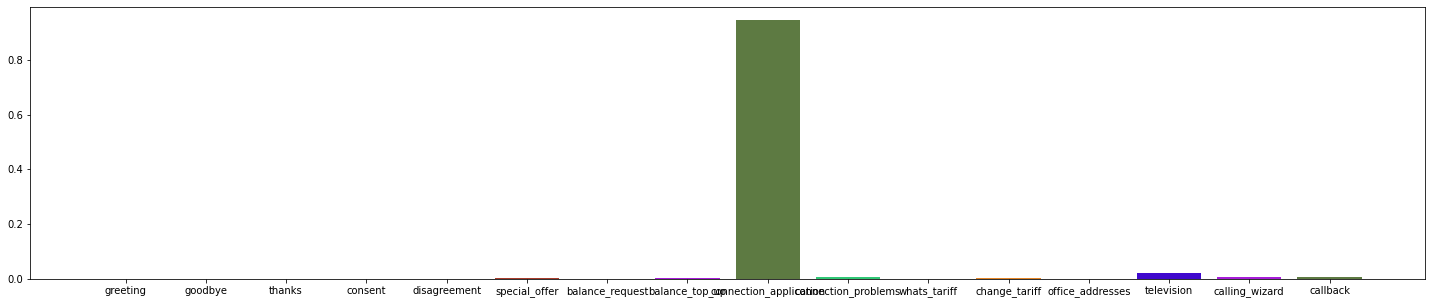

In [ ]:
x = classes_for_indexing
y = predict_list

fig, ax = plt.subplots()

color_rectangle = np.random.rand(7, 3) 
ax.bar(x, y, color = color_rectangle)

fig.set_figwidth(25)   
fig.set_figheight(5)   

plt.show()

**Пишем скрипт для чат-бота**

In [ ]:
from df_engine.core.keywords import GLOBAL, TRANSITIONS, RESPONSE
from df_engine.core import Context, Actor
import df_engine.conditions as cnd
from typing import Union

Предобрабатываем входящие запросы

In [ ]:
def preprocess_sent(text):

    new_letter = '' 

    for letter in text:
        if letter not in string.punctuation:
            new_letter += letter
            new_letter = new_letter.lower()    
    return new_letter  

Пишем функции для классификации 

In [ ]:
def intent_classifier(sent):
    p_sent = preprocess_sent(sent)
    tokens_input, token_embs_input, subtokens_input, subtoken_embs_input, sent_max_embs_input, sent_mean_embs_input, bert_pooler_outputs_input = model_input([p_sent])

    svc_predict = svc.predict(sent_mean_embs_input)
    predict_list = svc_predict.tolist()[0]
    return predict_list

In [ ]:
def about_greeting(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 0

def about_goodbye(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 1

def about_thanks(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 2

def about_consent(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 3

def about_disagreement(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 4

def about_special_offer(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 5

def about_balance_request(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 6

def about_balance_top_up(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 7

def about_connection_application(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 8

def about_connection_problems(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 9

def about_whats_tariff(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 10

def about_change_tariff(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 11

def about_office_addresses(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 12

def about_television(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 13

def about_calling_wizard(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 14

def about_callback(ctx, actor):
    sent = ctx.last_request
    return intent_classifier(sent) == 15    

In [ ]:
intent_classifier('расскажите о тв')

13

In [ ]:
script = {
    "greeting_flow": {
        "start_node": {
            RESPONSE: "",
            TRANSITIONS: {"node1": about_greeting,
                         ("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
        },
        "node1": {
            RESPONSE: "Рад Вас видеть! Чем могу помочь?",
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
        },
        "fallback_node": {
            RESPONSE: "Могу ли ещё чем-то помочь?",
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye,
                         ("disagreement_flow", "node1"): about_disagreement,
                         ("consent_flow", "node1"): about_consent}, 
        }
    },
    "goodbye_flow": {
            "node1": {
            RESPONSE: "Всего доброго!",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},
          }
        },
     "thanks_flow": {
            "node1": {
            RESPONSE: "Пожалуйста!",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},
          }
        },   
     "consent_flow": {
            "node1": {
            RESPONSE: "Чем ещё могу быть полезен?",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
          }
        },     
    "disagreement_flow": {
        "node1": {
            RESPONSE: "Понял Вас. Если что, я тут.",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},
          },
          "node2": {
            RESPONSE: "Хорошо. Если будут вопросы, обращайтесь!",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
          } 
        },
    "special_offer_flow": {
            "node1": {
            RESPONSE: "Все акции на сегодня:\n1.Приведи друга: получи скидку 50% для себя и для друга.\n2.Лестница скидок: скидка до 10% при оплате через мобильное приложение.\n3.Кешбэк: возвращайте до 20% от ежемесячных платежей.\n\nТакже для пенсионеров, инвалидов и ветеранов действуют программы лояльности.\n\nО чем Вам рассказать подробнее?",  
            TRANSITIONS: {"node2": cnd.regexp(".*друг.*|.*привед.*|.*перв.*|.*1.*|.*один.*"),
                          "node3": cnd.regexp(".*лестн.*|.*мобильн.*|.*прилож.*|.*2.*|.*втор.*|.*два.*"),
                          "node4": cnd.regexp(".*кеш.*|.*кэш.*|.*3.*|.*трет.*|.*три.*"),
                          "node5": cnd.regexp(".*льгот.*|.*пенс.*|.*инвал.*|.*ветер.*|.*програм.*|.*лояльн.*")},
          },  
          "node2": {
            RESPONSE: "В акции «Приведи друга» могут принимать участие только абоненты, подключенные к услугам провайдера.\nУчастник акции может получить скидку 50 % на стоимость тарифа за услугу Интернет.\nДля участия в акции необходимо порекомендовать провайдера своим соседям, друзьям, коллегам,\nзаполнить форму в личном кабинете, во вкладке «Акция Приведи друга»\nили при подключении попросить друга сообщить Ваш номер лицевого счета оператору.\nУчастие в акции позволяет получить скидку не только Вам, но и Вашему другу.\nАкцией можно воспользоваться неограниченное количество раз.\n\nПодробнее узнать об условиях проведения акции можно здесь.",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
          },
          "node3": {
            RESPONSE: "Все клиенты, пользующиеся услугами компании не менее 6 месяцев, а также производящие оплату рекомендованных платежей через мобильное приложение провайдера, автоматически становятся участниками акции и получают скидку в размере 3% на ежемесячную абонентскую плату по Вашему тарифному плану.\nСкидка 3%, 5%, 8% и 10% назначается автоматически в дату внесения очередного рекомендованного платежа, по прошествии 3, 6, 9, 12 месяцев отсутствия финансовой блокировки счета.\n\nПодробнее узнать об условиях проведения акции можно здесь.",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
            },
          "node4": {
            RESPONSE: "Для каждого абонента устанавливается переменная величина – процент кешбэка, которая изменяется по описанным ниже правилам.\nНачальное значение процента кешбэка – 2%. Максимальное значение процента кешбэка – 20%.\nПроцент кешбэка меняется в зависимости от количества Ваших расчётных периодов.\n\nПодробнее узнать об условиях проведения акции можно здесь.",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
            }, 
          "node5": {
            RESPONSE: "Пенсионеры, инвалиды и ветераны труда могут рассчитывать на существенную скидку при использовании аналогового или цифрового телевидения.\nКомпенсация может достигать 50% от суммы за услуги. Она зависит от подключенных тарифных планов и других факторов.\n\nТочный размер скидки можно узнать у специалиста call-центра или в офисе обслуживания.",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
            }  
        }, 
    "balance_request_flow": {
            "node1": {
            RESPONSE: "Для проверки баланса необходмо авторизоваться.\nВведите, пожалуйста, номер Вашего договора или полный адрес, а также Ф.И.О. владельца договора.",  
            TRANSITIONS: {"node2": cnd.regexp(".*\d+.*")},
          },
          "node2": {
            RESPONSE: "Петров Семён Иванович\nДоговор №840030\nМосква, Пушкина, 18\nБаланс – 120 руб.\n\nХотите пополнить баланс?",  
            TRANSITIONS: {("disagreement_flow", "node2"): about_disagreement,
                         "node3": about_consent},
          },
          "node3": {
            RESPONSE: "Выберите способ оплаты:\n1.Онлайн-оплата банковской картой.\n2.Онлайн-перевод через приложение банка.\n3.Оплата через QIWI Wallet.\n4.Оплата через терминал в офисе обслуживания.\n5.Оплата по квитанции в банке.",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},  
        } 
    },
    "balance_top_up_flow": {
            "node1": {
            RESPONSE: "Для пополнения баланса необходмо авторизоваться.\nВведите, пожалуйста, номер Вашего договора или полный адрес, а также Ф.И.О. владельца договора.",  
            TRANSITIONS: {"node2": cnd.regexp(".*\d+.*")},
          },
          "node2": {
            RESPONSE: "Петров Семён Иванович\nДоговор №840030\nМосква, Пушкина, 18\nБаланс – 0 руб.\n\nВыберите способ оплаты:\n1.Онлайн-оплата банковской картой.\n2.Онлайн-перевод через приложение банка.\n3.Оплата через QIWI Wallet.\n4.Оплата через терминал в офисе обслуживания.\n5.Оплата по квитанции в банке.",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},
          }
        },  
    "connection_application_flow": {
            "node1": {
            RESPONSE: "Что будем подключать?\n1.Интернет.\n2.Интернет + Кабельное ТВ.\n3.Кабельное ТВ.\n4.IP-телефония\n5.Интернет + Кабельное ТВ + IP-телефония",  
            TRANSITIONS: {"node6": cnd.regexp(".*Интерн.*каб.*телеф.*|.*интерн.*каб.*телеф.*|.*интерн.*тв.*телеф.*|.*5.*|.*пят.*|.*интерн.*телев.*телеф.*"),
                          "node5": cnd.regexp(".*Интерн.*каб.*|.*интерн.*каб.*|.*интерн.*ТВ.*|.*2.*|.*втор.*|.*интерн.*телев.*|.*Интерн.*тв.*|.*Интерн.*телев.*"),
                          "node4": cnd.regexp(".*каб.*|.*телев.*|.*3.*|.*трет.*|.*три.*|.*Каб.*|.*ТВ.*"),
                          "node3": cnd.regexp(".*телеф.*|.*IP*|.*Телеф.*|.*4.*|.*четв.*"),
                          "node2": cnd.regexp(".*интер.*|.*Интер.*|.*1*|.*перв.*|.*один.*")},
          },
          "node2": {
            RESPONSE: "Подключаем только Интернет.\nНапишите адрес, куда Вы планируете проводить подключение, и Ваш контактный номер.",  
            TRANSITIONS: {"node7": cnd.true()},
          },
          "node3": {
            RESPONSE: "Подключаем только IP-Телефонию.\nНапишите адрес, куда Вы планируете проводить подключение, и Ваш контактный номер.",  
            TRANSITIONS: {"node7": cnd.true()},
          },
          "node4": {
            RESPONSE: "Подключаем только кабельное телевидение.\nНапишите адрес, куда Вы планируете проводить подключение, и Ваш контактный номер.",  
            TRANSITIONS: {"node7": cnd.true()},
          },
          "node5": {
            RESPONSE: "Подключаем Комбо-2: Интернет + Кабельное ТВ.\nНапишите адрес, куда Вы планируете проводить подключение, и Ваш контактный номер.",  
            TRANSITIONS: {"node7": cnd.true()},
          },
          "node6": {
            RESPONSE: "Подключаем Комбо-3: Интернет + Кабельное ТВ + IP-телефония.\nНапишите адрес, куда Вы планируете проводить подключение, и Ваш контактный номер.",  
            TRANSITIONS: {"node7": cnd.true()},
          },
          "node7": {
            RESPONSE: "Заявка принята. С Вами свяжется менеджер для уточнения и подтверждения информации о подключении новой услуги.",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
          }
        },
    "connection_problems_flow": {
            "node1": {
            RESPONSE: "Возникли проблемы с Интернетом?\nЗдесь Вы можете самостоятельно ознакомиться с инструкциями по настройке интернет-соединения\nили попросить о помощи специалиста.",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
          }
        },            
    "whats_tariff_flow": {
            "node1": {
            RESPONSE: "Для уточнения информации о тарифе необходимо авторизоваться.\nВведите, пожалуйста, номер Вашего договора или полный адрес, а также Ф.И.О. владельца договора.",  
            TRANSITIONS: {"node2": cnd.true()},
          },
          "node2": {
            RESPONSE: "Петров Семён Иванович\nДоговор №840030\nМосква, Пушкина, 18\nБаланс – 0 руб.\n\nВаш тариф – Мега 250: 250 Мбит/с\nСкорость скачивания до 31.25 Мбайт/с\nСтоимость услуги – 500 руб. в месяц.",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
          }
        },
    "change_tariff_flow": {
            "node1": {
            RESPONSE: "Действующие тарифные планы:\n1.Мега 100: 100 Мбит/с\nСкорость скачивания до 12.5 Мбайт/с\nСтоимость услуги – 400 руб. в месяц.\n\n2.Мега 250: 250 Мбит/с\nСкорость скачивания до 31.25 Мбайт/с\nСтоимость услуги – 500 руб. в месяц.\n\n3.Мега 500: 500 Мбит/с\nСкорость скачивания до 62.5 Мбайт/с\nСтоимость услуги – 700 руб. в месяц.",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye,
                         ("thanks_flow", "node1"): about_thanks},
          }
        },   
    "office_addresses_flow": {
            "node1": {
            RESPONSE: "Адреса наших офисов:\nМосква, Ленина 28,6\nМосква, Карла Маркса,2\nМосква, Староалексеевская,5\nЕдиный номер обслуживания: +7(495)111-0000",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("television_flow", "node1"): about_television,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
          }
        }, 
    "television_flow": {
        "node1": {
            RESPONSE: "Доступны следующие пакеты ТВ",  
            TRANSITIONS: {("special_offer_flow", "node1"): about_special_offer,
                         ("balance_request_flow", "node1"): about_balance_request,
                         ("balance_top_up_flow", "node1"): about_balance_top_up,
                         ("connection_application_flow", "node1"): about_connection_application, 
                         ("connection_problems_flow", "node1"): about_connection_problems,
                         ("whats_tariff_flow", "node1"): about_whats_tariff,
                         ("change_tariff_flow", "node1"): about_change_tariff,
                         ("office_addresses_flow", "node1"): about_office_addresses,
                         ("calling_wizard_flow", "node1"): about_calling_wizard,
                         ("callback_flow", "node1"): about_callback,
                         ("goodbye_flow", "node1"): about_goodbye},
          }
        },         
    "calling_wizard_flow": {
        "node1": {
            RESPONSE: "Понял Вас.",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},
          },
          "node2": {
            RESPONSE: "Понял Вас.",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},
          }
        },
    "callback_flow": {
            "node1": {
            RESPONSE: "Оставьте Ваш контактный номер телефона, и оператор позвонит Вам в ближайшее время.",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},
          },
          "node2": {
            RESPONSE: "Понял Вас.",  
            TRANSITIONS: {("greeting_flow","start_node"): cnd.true()},
          }
        }                  
}

In [ ]:
actor = Actor(script, start_label=("greeting_flow", "start_node"), fallback_label=("greeting_flow", "fallback_node"))

In [ ]:
def turn_handler(in_request: str, ctx: Union[Context, dict], actor: Actor):
    ctx = Context.cast(ctx)
    ctx.add_request(in_request)
    ctx = actor(ctx)
    out_response = ctx.last_response
    return out_response, ctx

In [ ]:
ctx = {}
print('Здравствуйте, я Ваш виртуальный ассистент. Чем могу помочь?')
while True:
    in_request = input("Пользователь:")
    out_response, ctx = turn_handler(in_request, ctx, actor)
    print(out_response)